In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from PIL import Image


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
sample_submission_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv")
transactions_train_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")



In [3]:
import pandas as pd

transactions_train_df['customer_id'] =\
    transactions_train_df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')#try



transactions_train_df['article_id'] = transactions_train_df['article_id'].astype('int32')

transactions_train_df['article_id'] = '0' + transactions_train_df.article_id.astype('str')



transactions_train_df['price'] = transactions_train_df['price'].astype('float32')
transactions_train_df['sales_channel_id'] = transactions_train_df['sales_channel_id'].astype('int8')


In [4]:
#articles - contains informations about each article (like product code, name, product group code, name ...)
articles_df.head()
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [5]:
#customers - contains informations about each customer (fidelity card membership, age, postal code)
#postal_code is not correct , maybe we should remove it
customers_df.head()
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [6]:
#Transactions have customer_id and article_id, which are foreign keys for 
#the customer and articles tables. Beside this, transaction also contains sales_channel_id
transactions_train_df.head()
transactions_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       int64  
 2   article_id        object 
 3   price             float32
 4   sales_channel_id  int8   
dtypes: float32(1), int64(1), int8(1), object(2)
memory usage: 879.2+ MB


# Exploratory Data Analysis

**1. Check the missing value and what is the percentage of missing value in each feature.**

**2. Check how many unique observation in each feature.**

In [7]:
#Check the missing value and what is the percentage of missing value in each feature for customers data
#There is no missing value in customer_id and in postal_code ; club_member_status only has 0.4% missing value
#The feature of fashion_news_frequency and age contain round 1% missing values.
#The feature of Active and FN contains around 65 % missing value.

def missing_val_perc(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    return pd.concat([total,percent], axis = 1 , keys = ["total","%"])

missing_val_perc(customers_df)
#total1 = customers_df.isnull().sum().sort_values(ascending = False)
#percent1 = (customers_df.isnull().sum()/customers_df.isnull().count()*100).sort_values(ascending = False)
#df_isnull1 = pd.concat([total,percent],axis = 1,keys = ["total","percent"])
#df_isnull1

,total,%
customer_id,0,0.000000
FN,895050,65.237831
Active,907576,66.150819
club_member_status,6062,0.441843
fashion_news_frequency,16009,1.166854
age,15861,1.156066
postal_code,0,0.000000


In [8]:
#Check the missing value and what is the percentage of missing value in each feature for articles data
#The only one feature that has missing value is detail_desc which contains 0.4% missing values

missing_val_perc(articles_df)

,total,%
article_id,0,0.000000
product_code,0,0.000000
prod_name,0,0.000000
product_type_no,0,0.000000
product_type_name,0,0.000000
product_group_name,0,0.000000
graphical_appearance_no,0,0.000000
graphical_appearance_name,0,0.000000
colour_group_code,0,0.000000
colour_group_name,0,0.000000


In [9]:
#Check the missing value and what is the percentage of missing value in each feature for transactions_train data
#There is no missing value in this dataset 

missing_val_perc(transactions_train_df)

,total,%
t_dat,0,0.0
customer_id,0,0.0
article_id,0,0.0
price,0,0.0
sales_channel_id,0,0.0


In [10]:
#Check how many unique observation in each feature. 

def unique(data):
    total = data.count()
    df = pd.DataFrame (total)
    df.columns = ["total"]

    lst = []
    for col in data.columns:
        unique = len(data[col].unique())
        lst.append(unique)
    df['unique']= lst

    return df  


unique(articles_df)

,total,unique
article_id,105542,105542
product_code,105542,47224
prod_name,105542,45875
product_type_no,105542,132
product_type_name,105542,131
product_group_name,105542,19
graphical_appearance_no,105542,30
graphical_appearance_name,105542,30
colour_group_code,105542,50
colour_group_name,105542,50


In [11]:
unique(customers_df)


,total,unique
customer_id,1371980,1371980
FN,476930,2
Active,464404,2
club_member_status,1365918,4
fashion_news_frequency,1355971,5
age,1356119,85
postal_code,1371980,352899


In [12]:
unique(transactions_train_df)

,total,unique
t_dat,31788324,734
customer_id,31788324,1362281
article_id,31788324,104547
price,31788324,9857
sales_channel_id,31788324,2


**EDA -  Article Data**

**Check the how many obserations for each feature  in Article Data**

In [13]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [14]:
unique(articles_df)

,total,unique
article_id,105542,105542
product_code,105542,47224
prod_name,105542,45875
product_type_no,105542,132
product_type_name,105542,131
product_group_name,105542,19
graphical_appearance_no,105542,30
graphical_appearance_name,105542,30
colour_group_code,105542,50
colour_group_name,105542,50


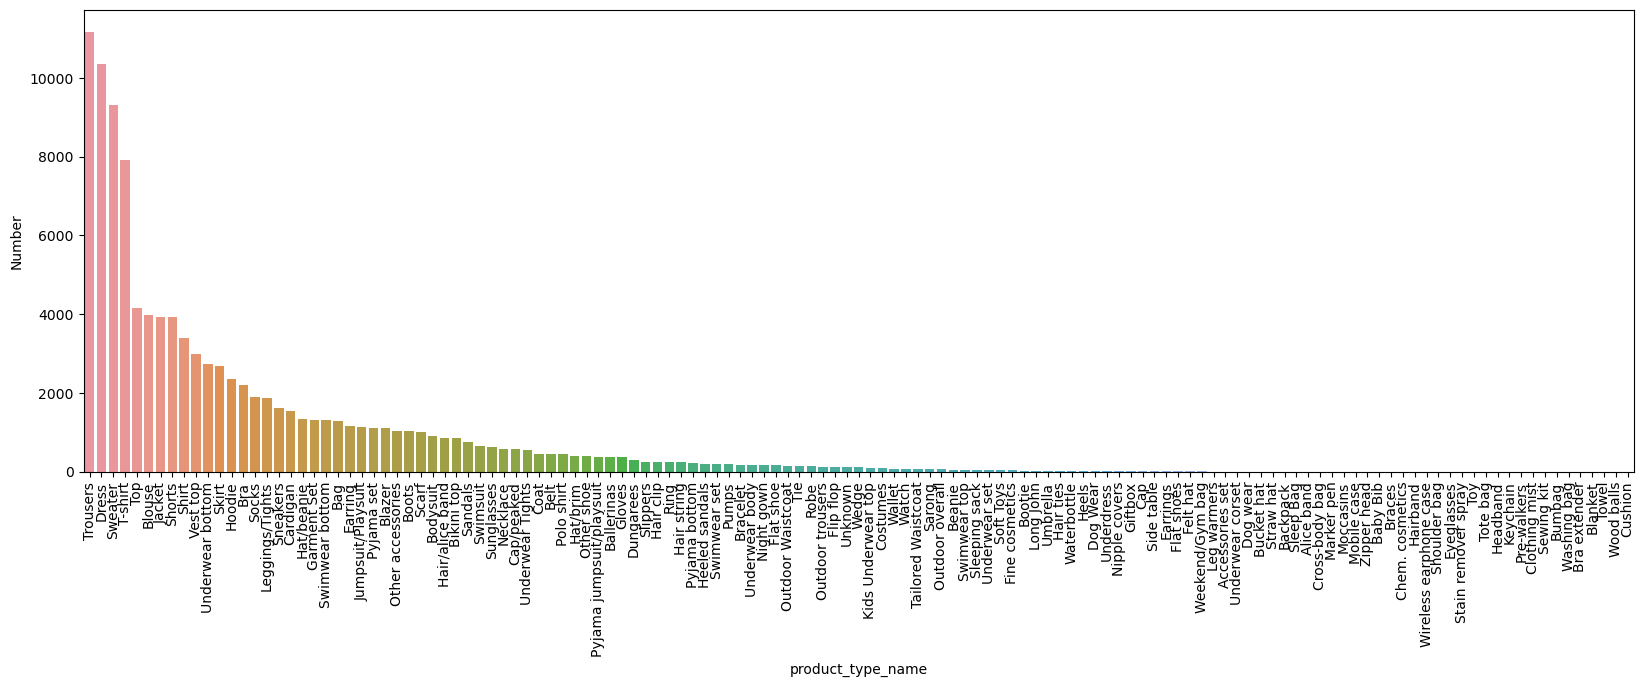

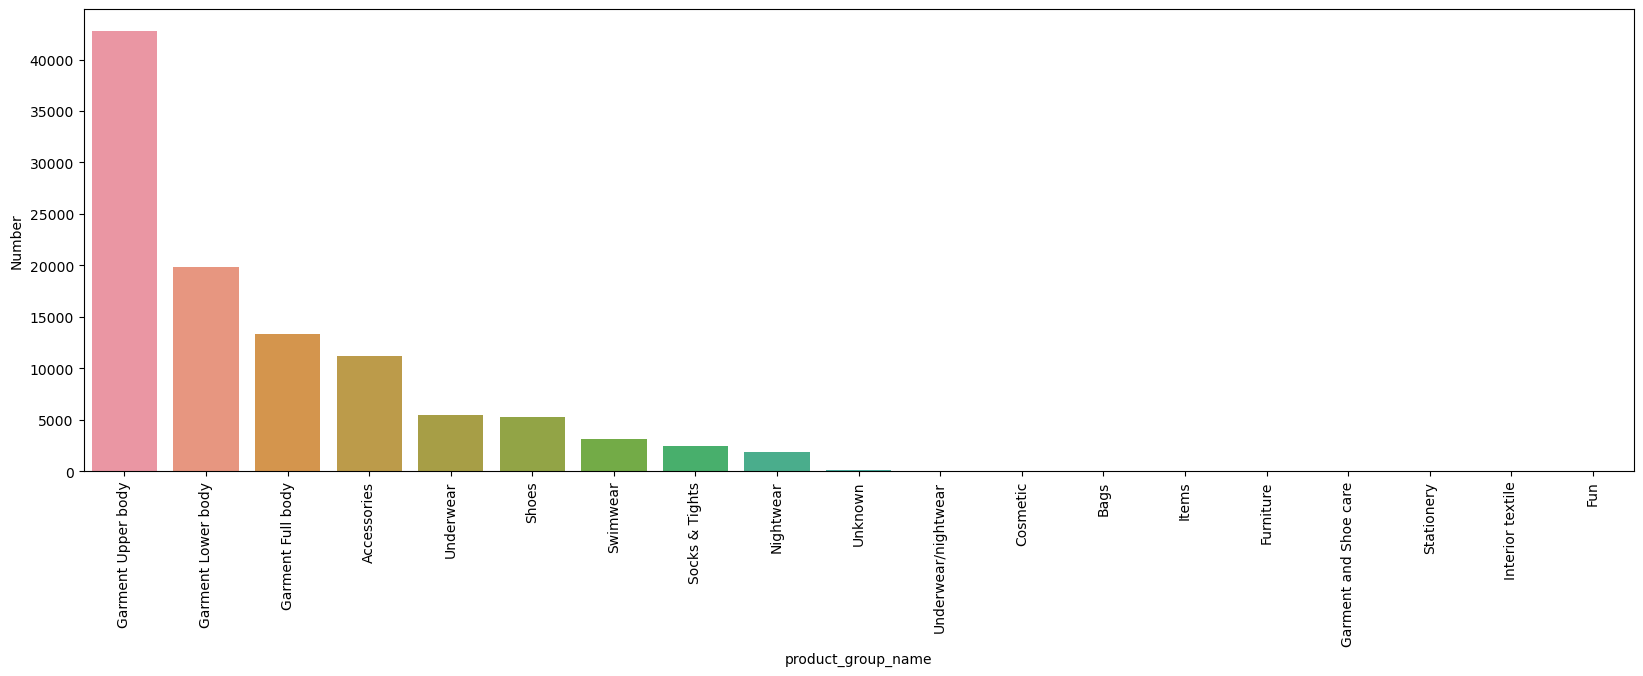

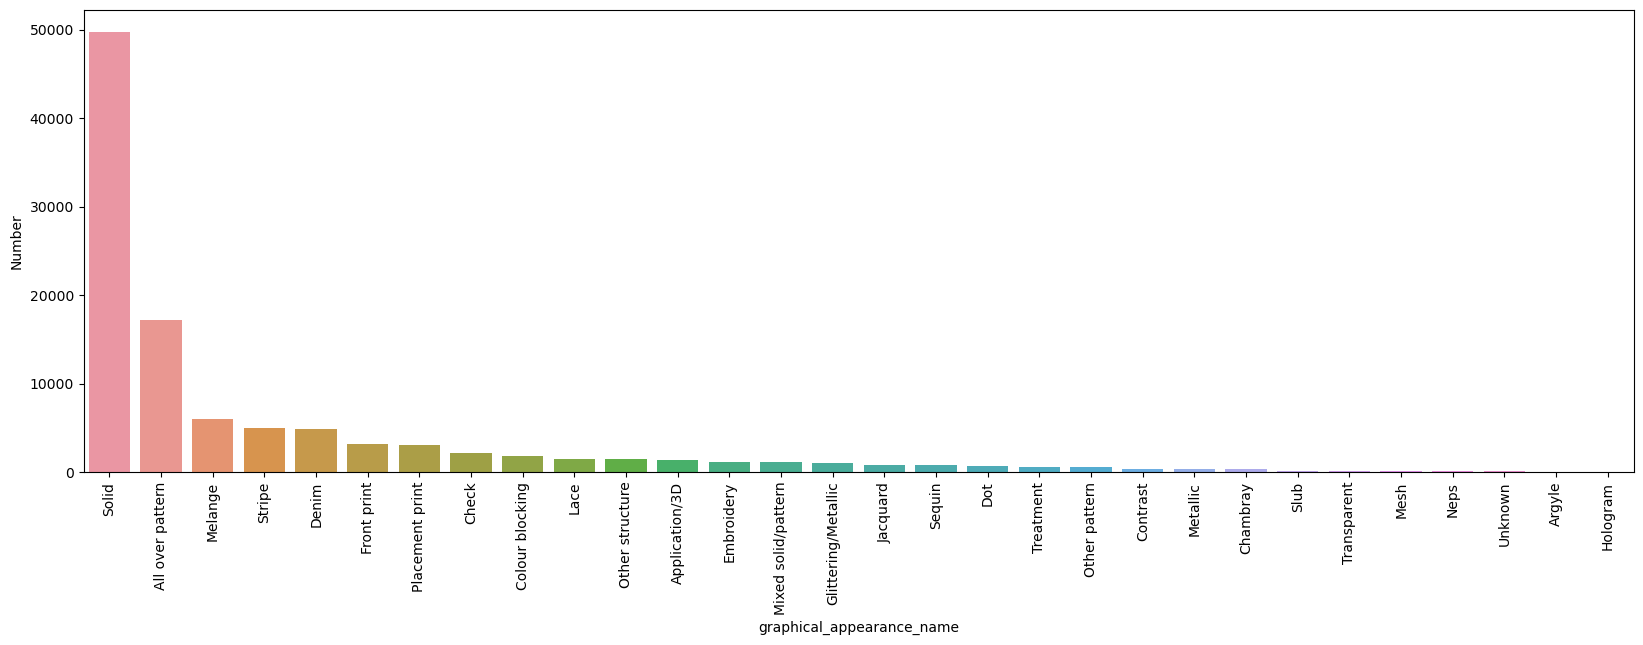

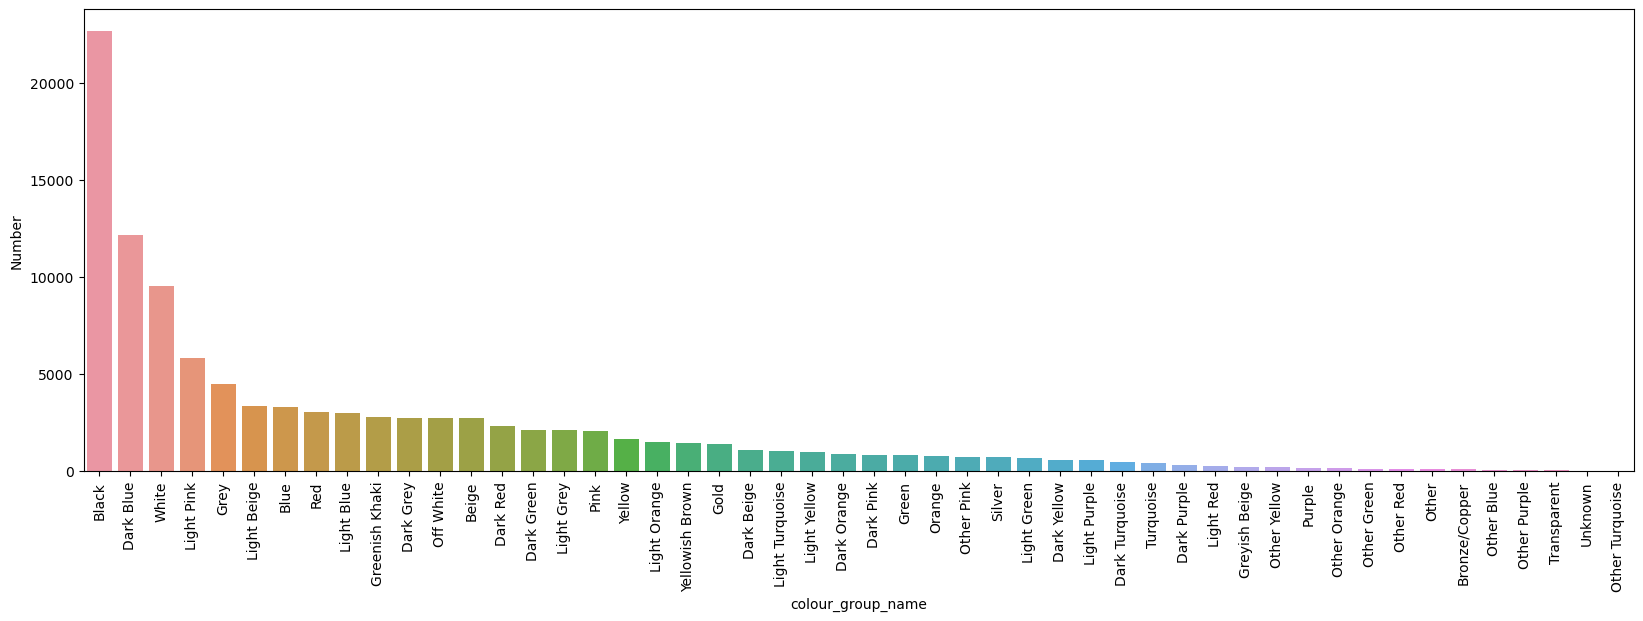

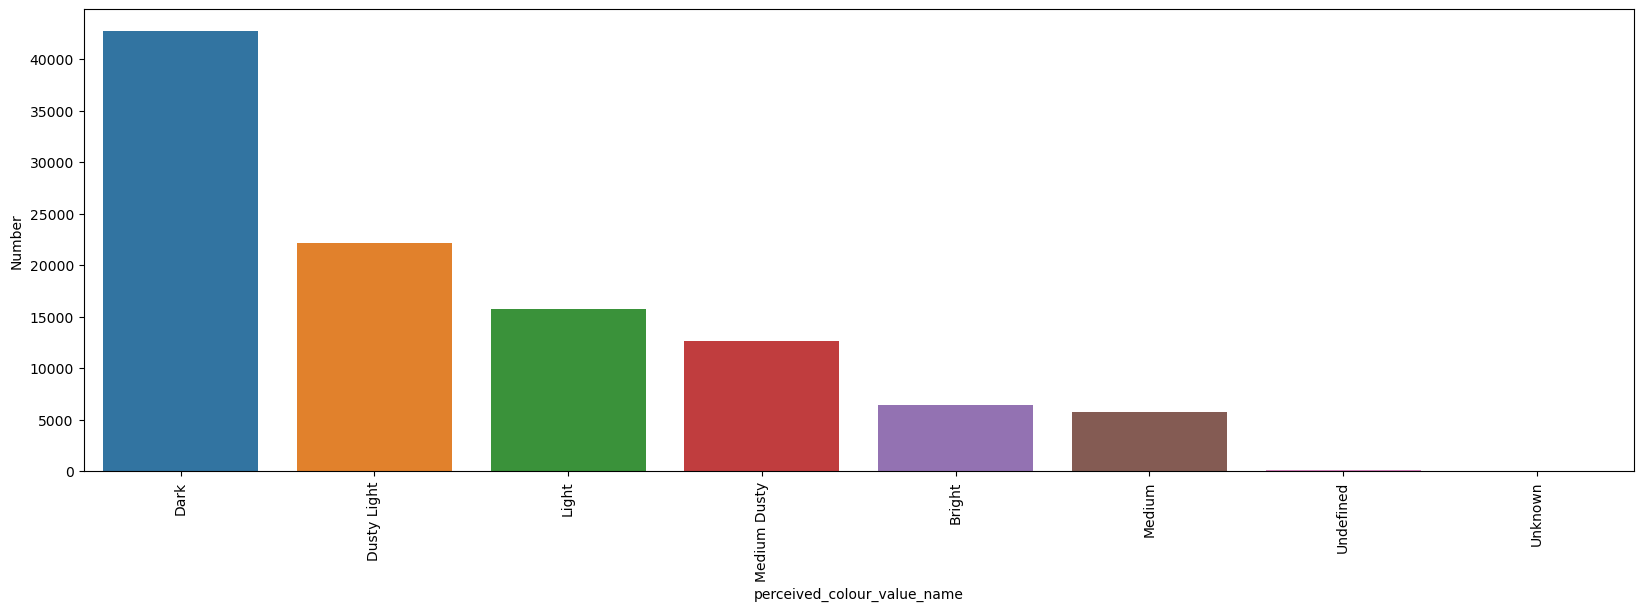

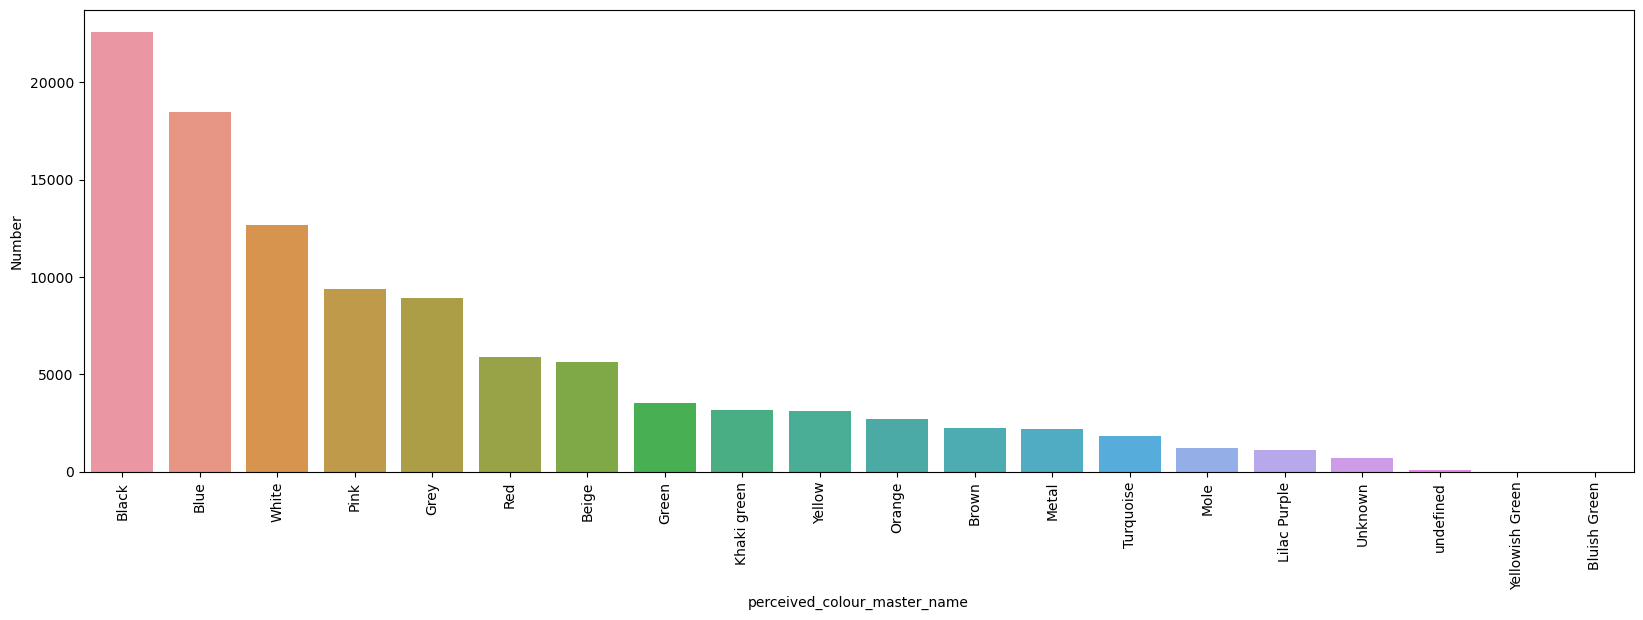

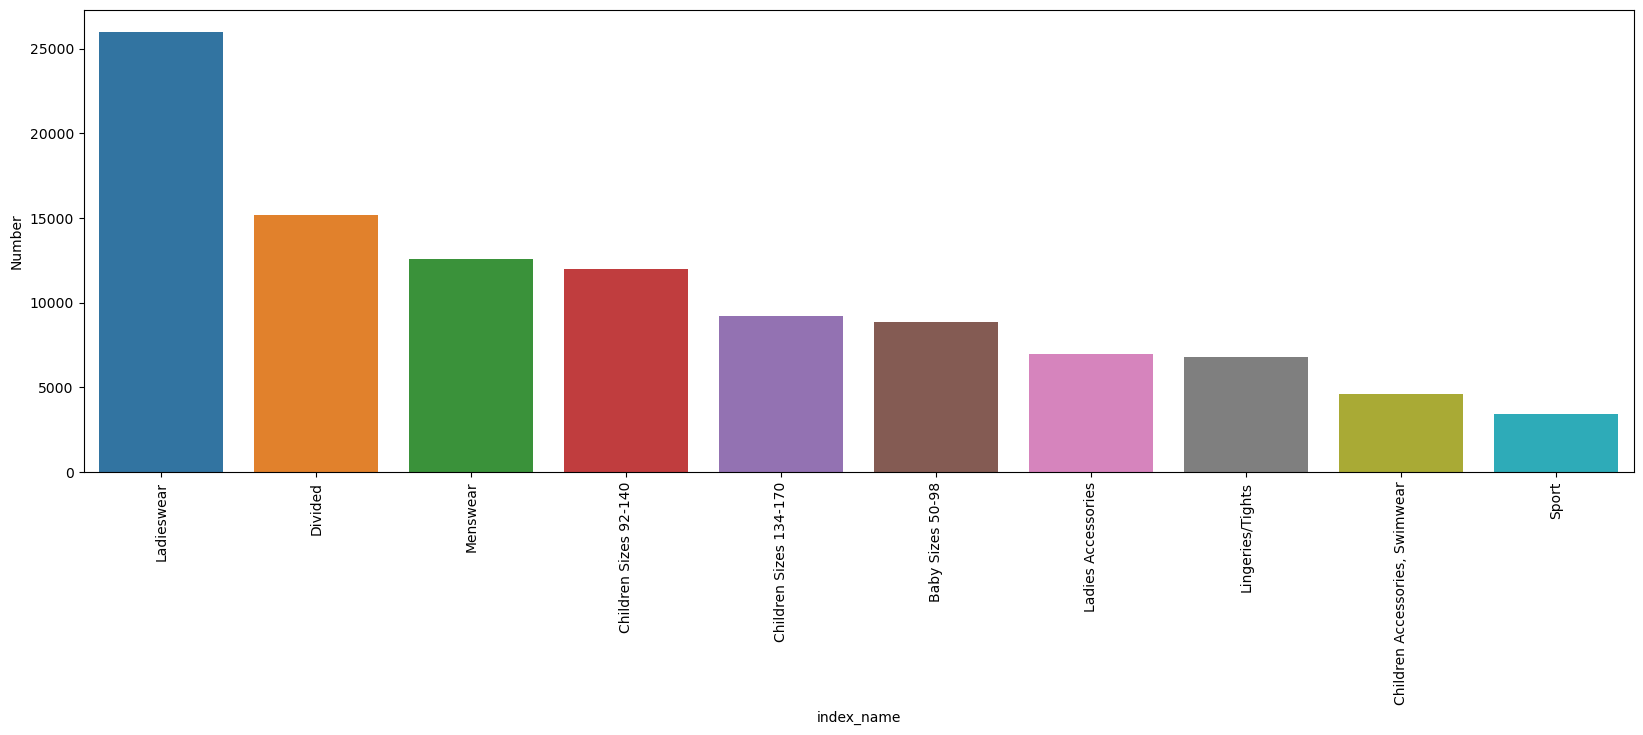

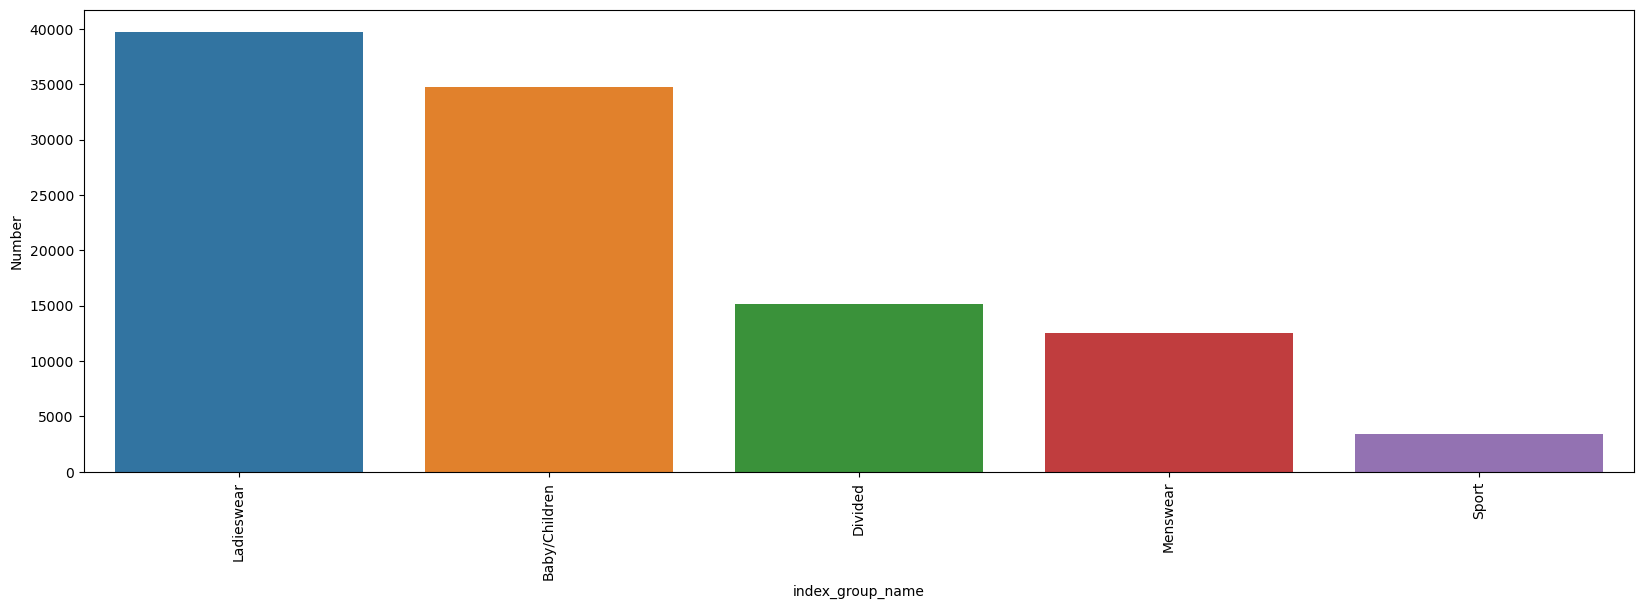

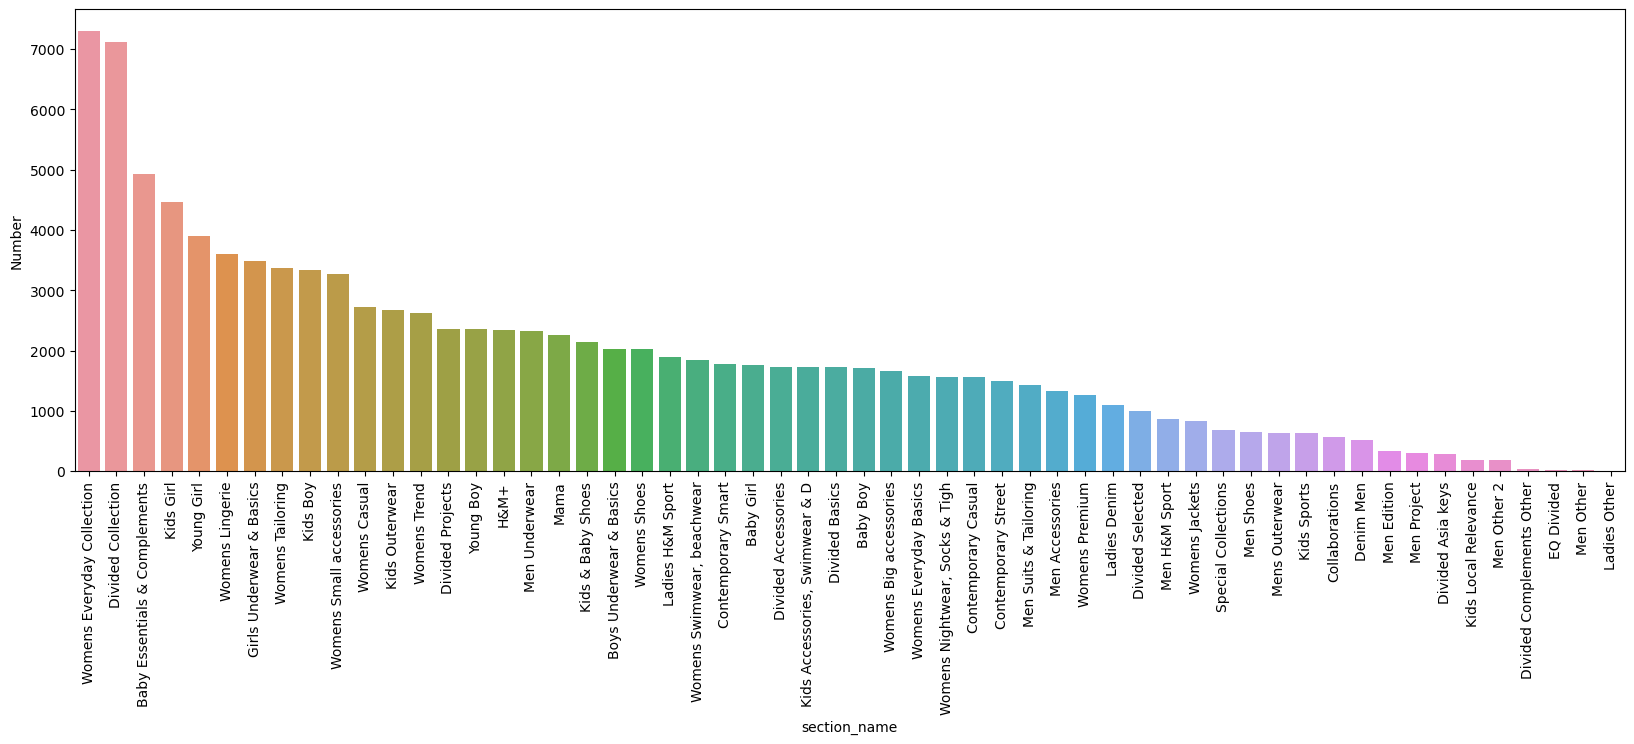

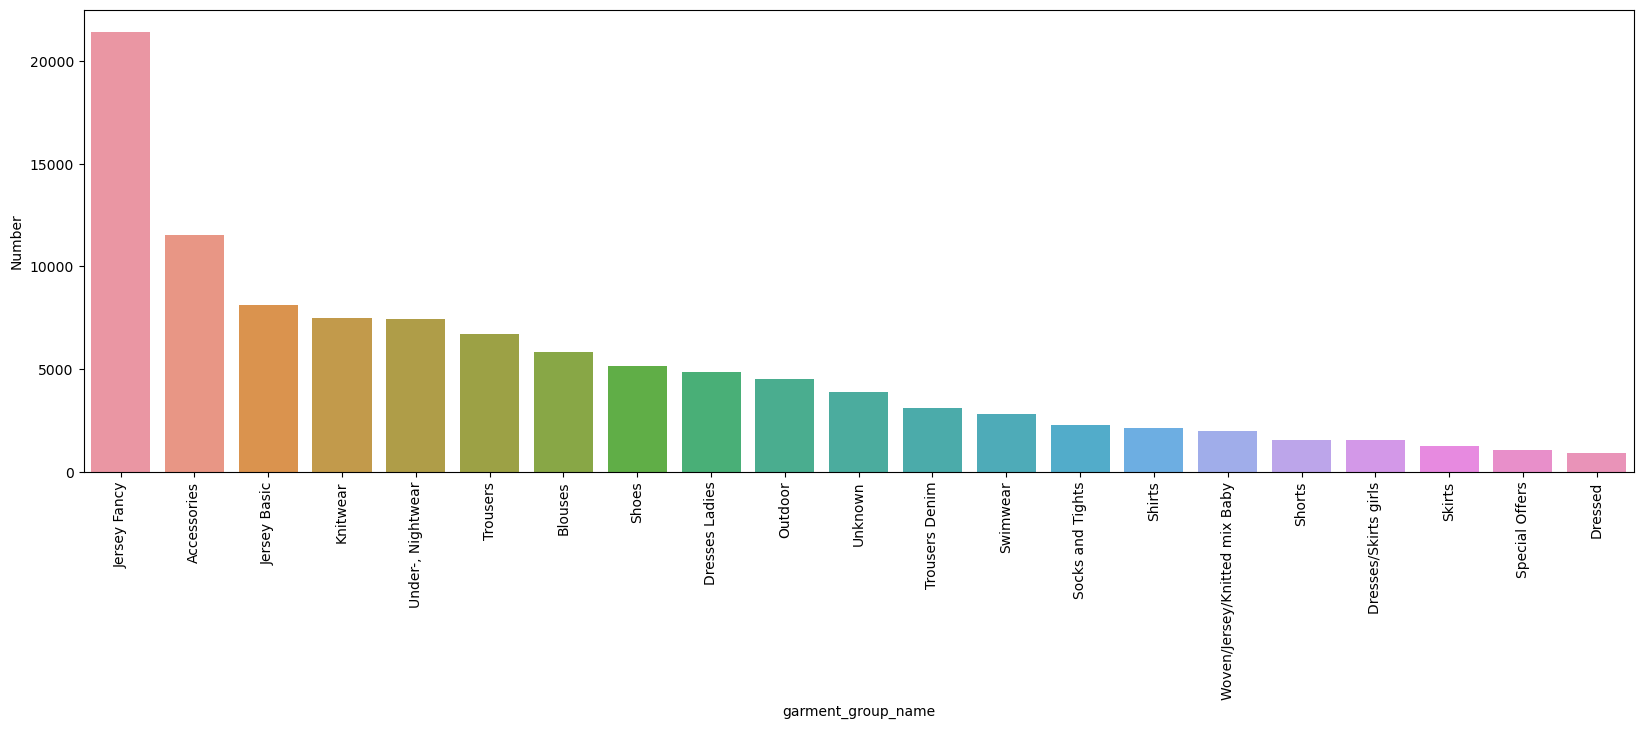

In [15]:


lst_article = ["product_type_name","product_group_name","graphical_appearance_name","colour_group_name",
              "perceived_colour_value_name","perceived_colour_master_name","index_name","index_group_name",
              "section_name","garment_group_name"]


for col in lst_article :
    group1 =articles_df.groupby([col])["article_id"].nunique()
    df1 = pd.DataFrame({col:group1.index,"Number":group1.values})
    df1=df1.sort_values(["Number"], ascending=False)
    plt.figure(figsize = (20,6))
    plt.title = "Amount in each product group "
    ax = sns.barplot(x= col, y="Number", data =df1  )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()

**EDA -  Customer Data**

**Check the how many obserations for each feature  in Customer**

In [16]:
unique(customers_df)

,total,unique
customer_id,1371980,1371980
FN,476930,2
Active,464404,2
club_member_status,1365918,4
fashion_news_frequency,1355971,5
age,1356119,85
postal_code,1371980,352899


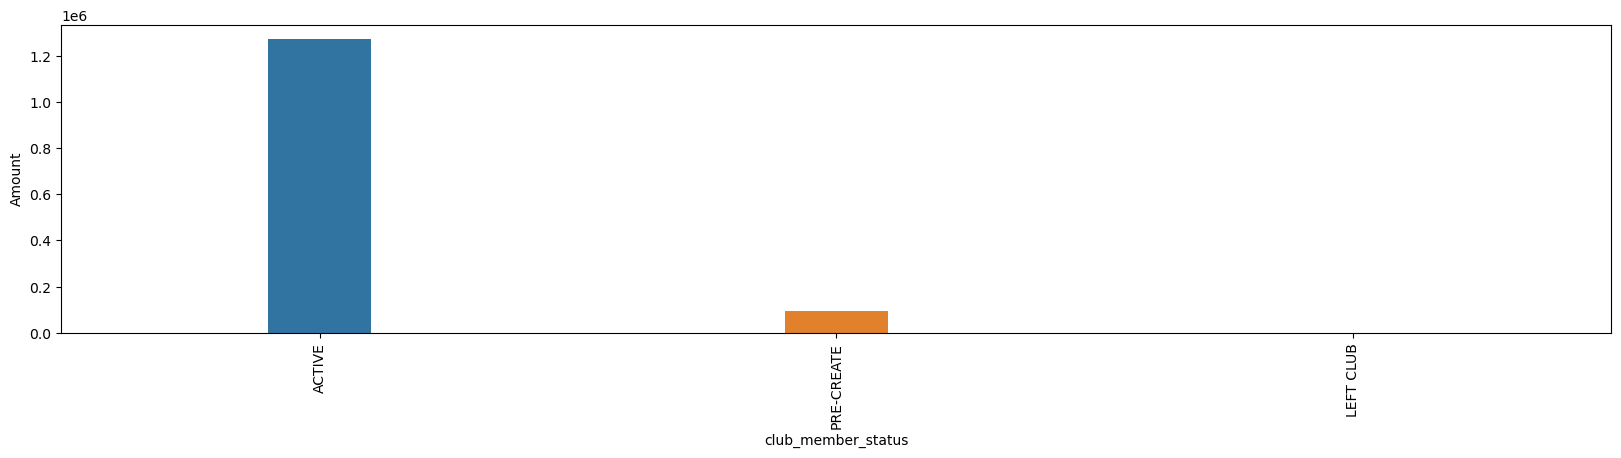

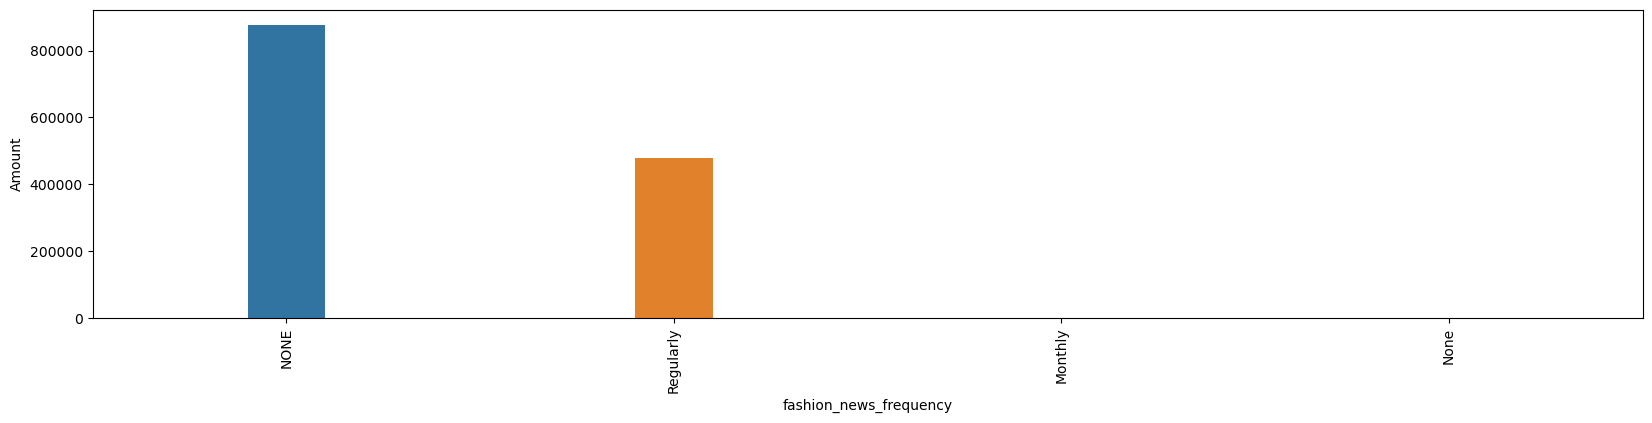

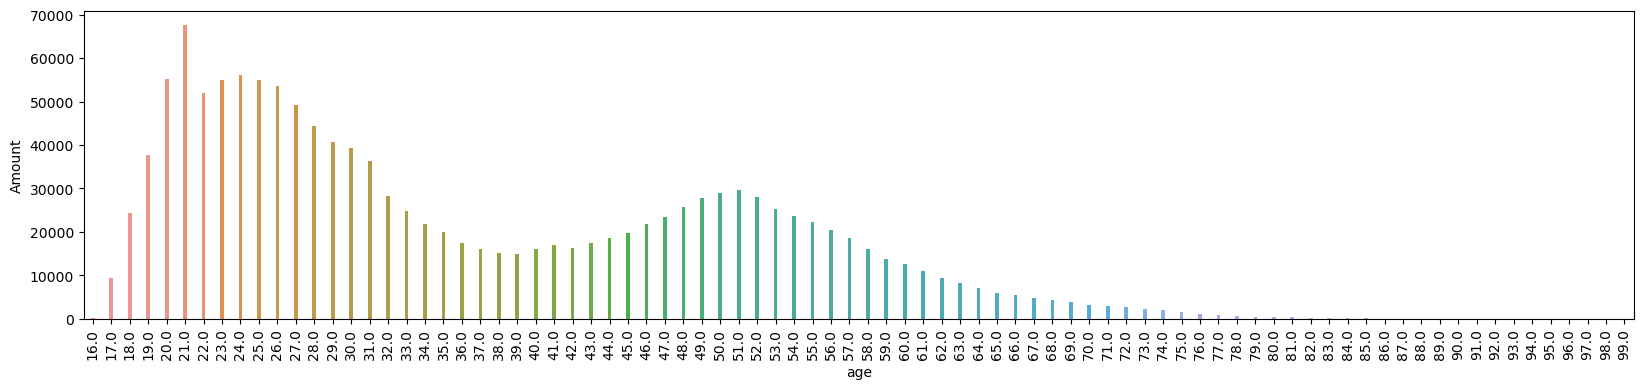

In [17]:
lst_cutomer = ["club_member_status","fashion_news_frequency","age"]
for col2 in lst_cutomer:
    group2 = customers_df.groupby([col2])["customer_id"].nunique()
    group2_df = pd.DataFrame({col2:group2.index,"Amount":group2.values})
    group2_df=group2_df.sort_values(["Amount"],ascending=False)
    plt.figure(figsize = (20,4))
    plt.title = "Amount of observation in each catagory"
    axes2 = sns.barplot(x= col2, y = "Amount", data =group2_df,width=.2 )
    axes2.set_xticklabels(axes2.get_xticklabels(),rotation=90)
    plt.show()

**EDA -  Transaction Data**
​


In [18]:
unique(transactions_train_df)

,total,unique
t_dat,31788324,734
customer_id,31788324,1362281
article_id,31788324,104547
price,31788324,9857
sales_channel_id,31788324,2


In [19]:
transactions_train_df

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,0663713001,0.050831,2
1,2018-09-20,-6846340800584936,0541518023,0.030492,2
2,2018-09-20,-8334631767138808638,0505221004,0.015237,2
3,2018-09-20,-8334631767138808638,0685687003,0.016932,2
4,2018-09-20,-8334631767138808638,0685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,4685485978980270934,0929511001,0.059305,2
31788320,2020-09-22,4685485978980270934,0891322004,0.042356,2
31788321,2020-09-22,3959348689921271969,0918325001,0.043203,1
31788322,2020-09-22,-8639340045377511665,0833459002,0.006763,1


In [20]:
# sampling 30,000 from 31,788,323 observations 

new_df = transactions_train_df.sample(30000, replace=False).sort_values(["t_dat"])
new_df1 = new_df.groupby(["t_dat"])["article_id"].count()

new_df2 = pd.DataFrame({"Date":new_df1.index,"Volumns":new_df1.values})
new_df2 

,Date,Volumns
0,2018-09-20,25
1,2018-09-21,46
2,2018-09-22,18
3,2018-09-23,46
4,2018-09-24,44
...,...,...
729,2020-09-18,36
730,2020-09-19,35
731,2020-09-20,23
732,2020-09-21,30


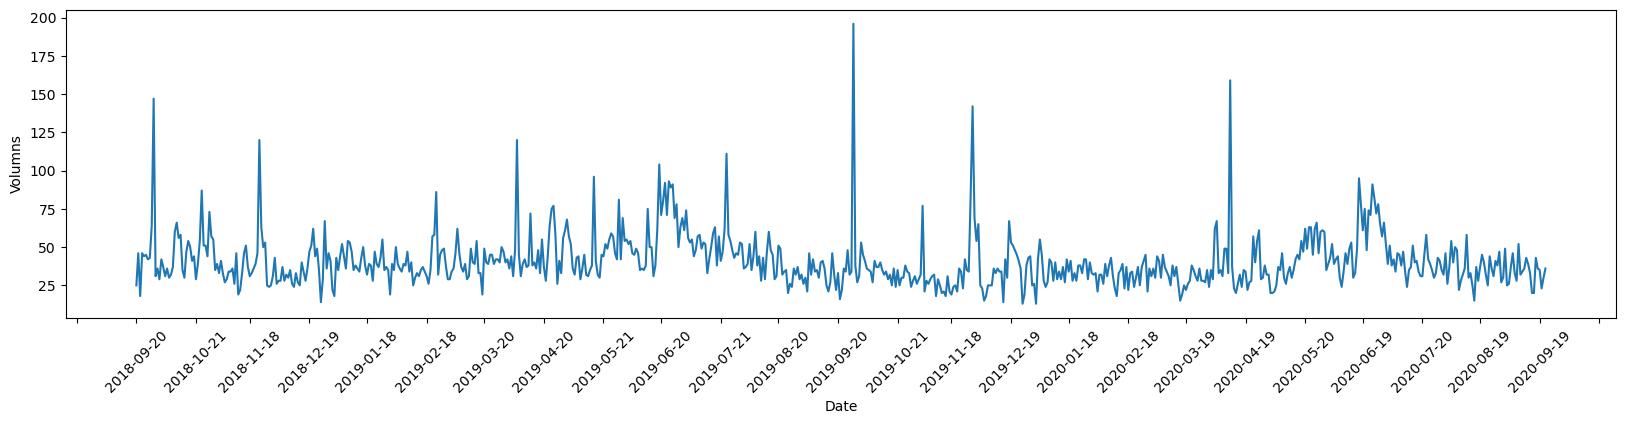

In [21]:
#sales volumn per data
import matplotlib.dates as mdates


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

plt.figure(figsize = (20,4))
plt.title = "Amount of observation in each catagory"
axes3 = sns.lineplot(x = "Date", y = "Volumns",
             data = new_df2 )
locator = mdates.MonthLocator()
axes3.xaxis.set_major_locator(locator)
plt.xticks(rotation=45)
plt.show()



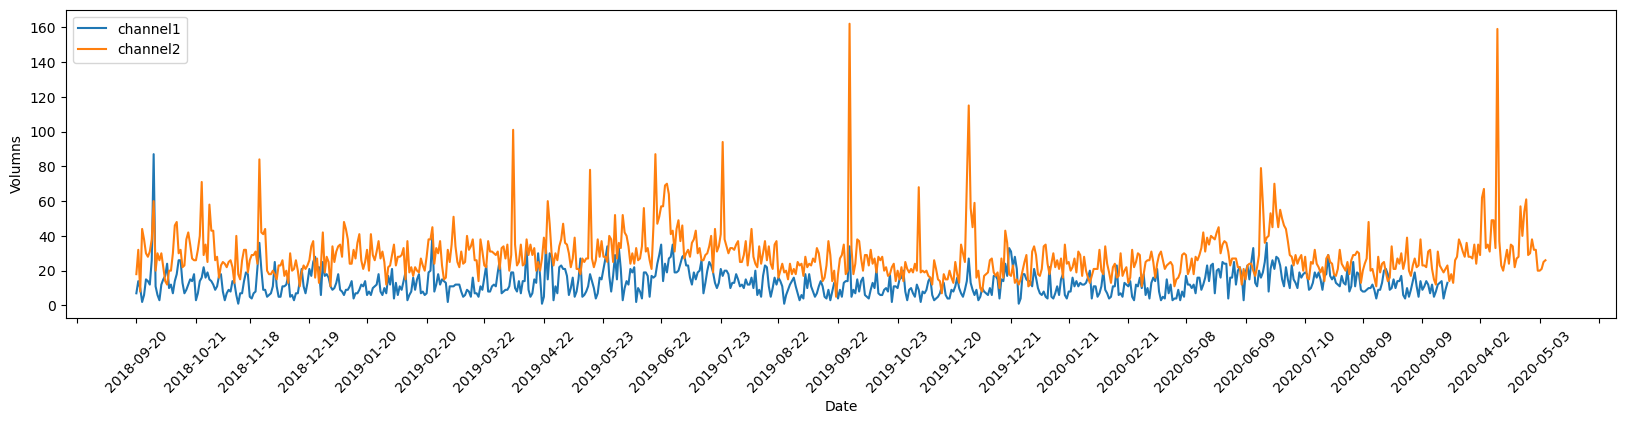

In [22]:
#plot daily sales volumns of each channel

channel1 = new_df[new_df["sales_channel_id"]==1]
channel2 = new_df[new_df["sales_channel_id"]==2]

new_df3 = channel1.groupby(["t_dat"])["article_id"].count()
new_df4 = pd.DataFrame({"Date":new_df3.index,"Volumns":new_df3.values})

new_df5 = channel2.groupby(["t_dat"])["article_id"].count()
new_df6 = pd.DataFrame({"Date":new_df5.index,"Volumns":new_df5.values})

plt.figure(figsize = (20,4))
plt.title = "Amount of observation in each catagory"
axes4 = sns.lineplot(x = "Date", y = "Volumns",
             data = new_df4 ,label="channel1" )
axes6 = sns.lineplot(x = "Date", y = "Volumns",
             data = new_df6 ,label="channel2" )
locator = mdates.MonthLocator()
axes4.xaxis.set_major_locator(locator)


plt.xticks(rotation=45)
plt.show()

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
sns.set(rc = {'figure.figsize':(15,8)})

In [25]:
### Visualization for original dataset.
df = transactions_train_df['t_dat'].value_counts().rename_axis('date').reset_index(name='Purchases')
df.head()

,date,Purchases
0,2019-09-28,198622
1,2020-04-11,162799
2,2019-11-29,160875
3,2018-11-23,142018
4,2018-09-29,141700


In [26]:
df["Period"] = pd.to_datetime(df["date"])
df.head()

,date,Purchases,Period
0,2019-09-28,198622,2019-09-28
1,2020-04-11,162799,2020-04-11
2,2019-11-29,160875,2019-11-29
3,2018-11-23,142018,2018-11-23
4,2018-09-29,141700,2018-09-29


In [27]:
df = df.set_index("Period")
df

,date,Purchases
Period,,
2019-09-28,2019-09-28,198622
2020-04-11,2020-04-11,162799
2019-11-29,2019-11-29,160875
2018-11-23,2018-11-23,142018
2018-09-29,2018-09-29,141700
...,...,...
2019-01-01,2019-01-01,18145
2018-09-22,2018-09-22,17635
2018-12-25,2018-12-25,14799


In [28]:
df["year"] = df.index.year
df["Month"] = df.index.month_name()
df["month_number"] = df.index.month
df = df.sort_values('month_number')
df.head()

,date,Purchases,year,Month,month_number
Period,,,,,
2020-01-01,2020-01-01,12760,2020,January,1
2020-01-29,2020-01-29,36833,2020,January,1
2019-01-09,2019-01-09,53309,2019,January,1
2020-01-09,2020-01-09,36746,2020,January,1
2020-01-23,2020-01-23,36257,2020,January,1


[Text(0.5, 1.0, 'Purchases over the years 2018-2020')]

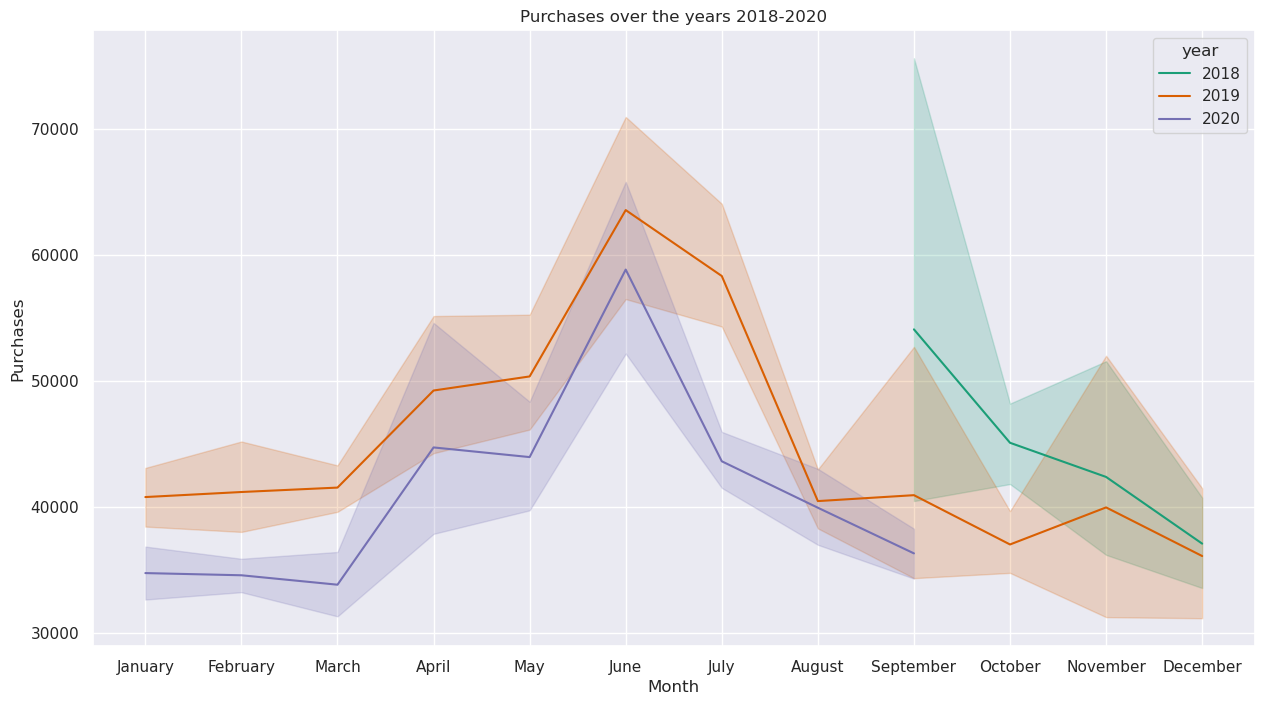

In [29]:
sns.lineplot(x="Month", y="Purchases", data=df, hue="year", palette="Dark2").set(title='Purchases over the years 2018-2020')

**Data Preprocessing**

Since we can detect a yearly sales volumn cycle from previous figure, here I'll use the data from Jan to Jun in 2019 as training dataset and data from Jan to Jun in 2020 as test and validation dataset

In [30]:
transactions_train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,0663713001,0.050831,2
1,2018-09-20,-6846340800584936,0541518023,0.030492,2
2,2018-09-20,-8334631767138808638,0505221004,0.015237,2
3,2018-09-20,-8334631767138808638,0685687003,0.016932,2
4,2018-09-20,-8334631767138808638,0685687004,0.016932,2


In [31]:
def query_based_on_date(df, start, end):
    x = df[(df['t_dat']>start) & (df['t_dat']<=end)]
    return x

In [32]:
train_x = query_based_on_date(transactions_train_df,"2019-01-01","2019-07-01")
train_x.shape

(8699838, 5)

In [33]:
test_x = query_based_on_date(transactions_train_df,"2020-01-01","2020-07-01")
test_x.shape

(7639852, 5)

In [34]:
train_x.head()

,t_dat,customer_id,article_id,price,sales_channel_id
4429407,2019-01-02,-1485175539946425831,0712519001,0.042356,1
4429408,2019-01-02,-1485175539946425831,0673677002,0.016932,1
4429409,2019-01-02,-1485175539946425831,0574069004,0.018627,1
4429410,2019-01-02,-1324432869547582252,0509629008,0.016932,2
4429411,2019-01-02,-1324432869547582252,0464908039,0.016932,2


**Check the customers that existing in both train and test data set**

In [35]:
train_customers = set(train_x["customer_id"].unique().tolist())
print(len(train_customers))

731691


In [36]:
test_customers= set(test_x["customer_id"].unique().tolist())
print(len(test_customers))

732369


In [37]:
overlap = train_customers.intersection(test_customers)
print(len(overlap))

433832


In [38]:
remove = test_customers - overlap

test_customers-=remove

print(len(test_customers))

433832


In [39]:
test_x1 =test_x[test_x["customer_id"].isin(overlap)==True]
test_x1.shape

(5723393, 5)